In [1]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from plot_model_training import *

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [3]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [4]:
in_dir = '/home/cali/data/GapFilling/CRISFull/'
pic_dir = 'Picture/'
result_dir = 'Result/'
data_dir = 'Data/'
model_dir = 'Model'
for _dir in [pic_dir, pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)

# 合成全部的CRIS_full数据

In [5]:
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()

cris_full_data_file = os.path.join(data_dir, 'CRIS_full_data.hdf')
if not os.path.isfile(cris_full_data_file):
    combine_cris_full_data(in_files, cris_full_data_file)

# 加载全部波段数据

In [6]:
X_all, Y_all = load_cris_full_combine_data(cris_full_data_file, None)

(1169003, 2211) (1169003, 1158)


In [7]:
print(type(X_all))
print(type(Y_all))

print(X_all.shape)
print(Y_all.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1169003, 2211)
(1169003, 1158)


In [8]:
# 判断是否有小于0和等于nan的无效值
print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


In [9]:
# 所有测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X_all = [(650., 1095., 0.625), (1210., 1750., 0.625), (2155., 2550., 0.625), ]
ranges_Y_all = [(1095.625, 1209.375, 0.625), (1750.625, 2154.375, 0.625), (2550.625, 2755., 0.625), ]

# 当前测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X = ranges_X_all
# ranges_X = [(650., 1095, 0.625), ]
# ranges_X = [(1210., 1750, 0.625), ]
# ranges_X = [(2155., 2550., 0.625), ]
ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375, 0.625), ]
# ranges_Y = [(1750.625, 2154.375, 0.625), ]
# ranges_Y = [(2550.625, 2755., 0.625), ]

# 加载预测波段的数据

In [10]:
data = load_train_data_from_all(X_all, Y_all, ranges_X_all, ranges_Y_all, ranges_X, ranges_Y)

In [11]:
train_X = data['train_X']
test_X = data['test_X']
train_Y = data['train_Y']
test_Y = data['test_Y']
wavenumber_X = data['wavenumber_X']
wavenumber_Y = data['wavenumber_Y']
index_X = data['index_X']
index_Y = data['index_Y']

(array([  10,   11,   12, ..., 2208, 2209, 2210]),)
(array([  29,   30,   31, ..., 2208, 2209, 2210]),)


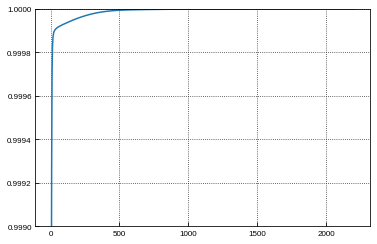

In [101]:
# pca = PCA()
# pca.fit(train_X)
# explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# plt.plot(explained_variance_ratio)
# print(np.where(explained_variance_ratio>0.99950))
# print(np.where(explained_variance_ratio>0.99990))
# plt.ylim(0.999, 1.)
# plt.show()

In [197]:
pc_count = [110, 30, 190, 230]

In [163]:
from sklearn.decomposition import PCA
x_pc = pc_count[0]
pca_x = PCA(x_pc)
train_X_pca = pca_x.fit_transform(train_X)
train_X_repreject = pca_x.inverse_transform(train_X_pca)
print(mean_squared_error(train_X, train_X_repreject))

0.0015060017


In [164]:
test_X_pca = pca_x.transform(test_X)
test_X_repreject = pca_x.inverse_transform(test_X_pca)

In [198]:
# 没有用错数据，但是Y重投影以后，与原来数据的差异特别大，这里需要Debug，目前怀疑是保留pc数量的问题
y_pc = pc_count[1:]

train_Y_repreject = None
test_Y_repreject = None

for y_pc_, [s, e] in zip(y_pc, index_Y):
    
#     pca = PCA()
#     pca.fit(train_Y[:, s:e])
#     explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
#     plt.plot(explained_variance_ratio)
#     plt.ylim(0.999, 1.)
#     print(np.where(explained_variance_ratio>0.99950))
#     print(np.where(explained_variance_ratio>0.99990))
#     plt.show()

    pca_y = PCA(y_pc_)
    y_part = train_Y[:, s:e]
    pca_y.fit(y_part)
    y_ = pca_y.transform(y_part)
    y_pca = pca_y.inverse_transform(y_)
    if train_Y_repreject is None:
        train_Y_repreject = y_pca
    else:
        train_Y_repreject = np.concatenate((train_Y_repreject, y_pca), axis=1)
    print(mean_squared_error(y_part, y_pca))

    y_part = test_Y[:, s:e]
    y_ = pca_y.transform(y_part)
    y_pca = pca_y.inverse_transform(y_)
    if test_Y_repreject is None:
        test_Y_repreject = y_pca
    else:
        test_Y_repreject = np.concatenate((test_Y_repreject, y_pca), axis=1)
    print(mean_squared_error(y_part, y_pca))

print(mean_squared_error(train_Y_repreject, train_Y))
print(mean_squared_error(test_Y_repreject, test_Y))

0.008516434
0.008520203
8.336873e-05
8.343622e-05
2.6668665e-06
2.6701791e-06
0.0013931966
0.0013938308


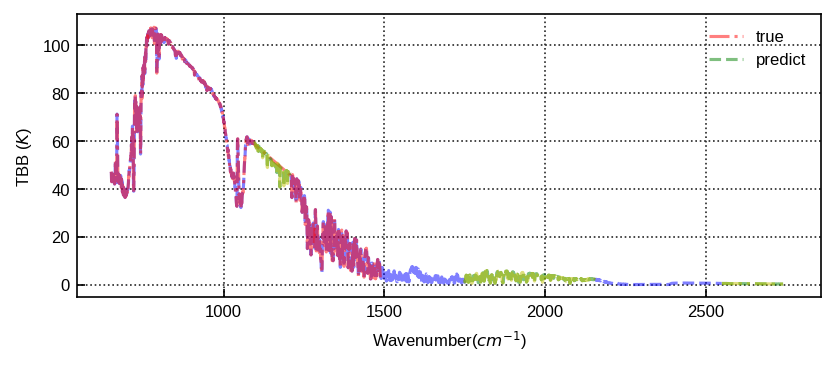

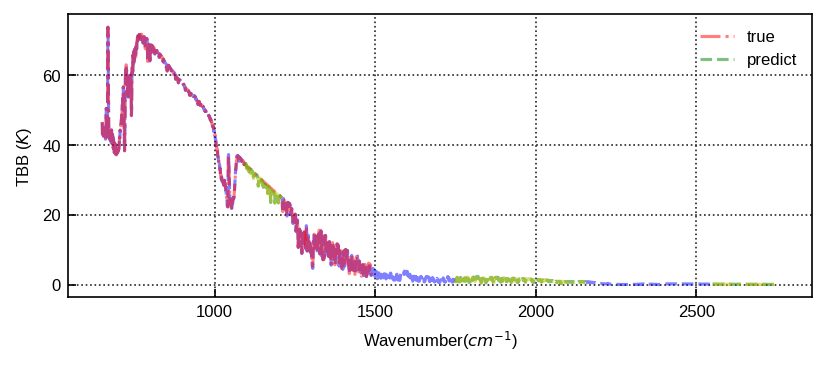

In [166]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], train_X[data_number][s: e], 'b--', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], train_X_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y[data_number][s: e], 'g--', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

In [167]:
train_X_tbb_repreject = rad2tbb(train_X_repreject, wavenumber_X)

/home/cali/src/gap_filling/util.py:77: RuntimeWarning: invalid value encountered in log
  tbb = (c2 * center_wave) / np.log(1 + ((c1 * center_wave ** 3) / radiance))


In [168]:
train_X_tbb = rad2tbb(train_X, wavenumber_X)

In [169]:
train_Y_tbb_repreject = rad2tbb(train_Y_repreject, wavenumber_Y)

In [170]:
train_Y_tbb = rad2tbb(train_Y, wavenumber_Y)

In [171]:
test_X_tbb_repreject = rad2tbb(test_X_repreject, wavenumber_X)

In [172]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

In [173]:
test_Y_tbb_repreject = rad2tbb(test_Y_repreject, wavenumber_Y)

In [174]:
test_Y_tbb = rad2tbb(test_Y, wavenumber_Y)

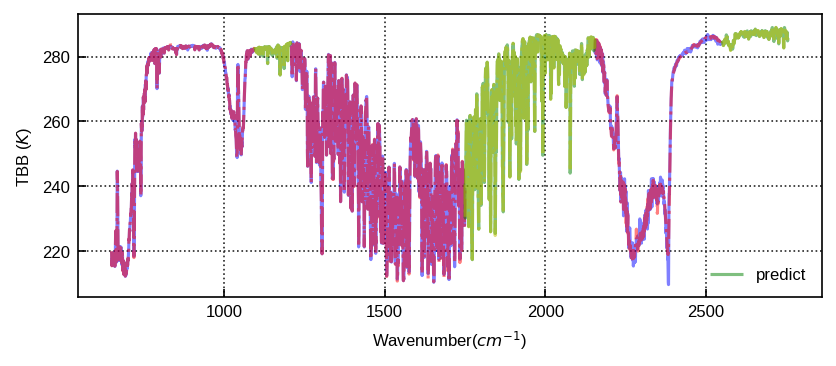

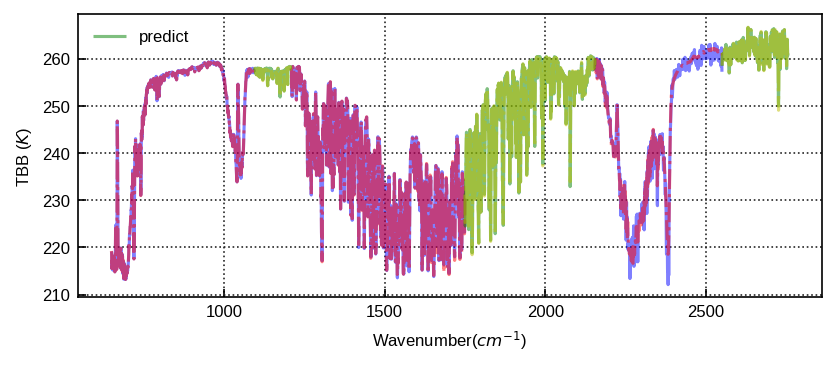

In [175]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], train_X_tbb[data_number][s: e], 'b-', alpha=alpha)
        plot_true_label = True
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true_repreject'
        plt.plot(wavenumber_X[s: e], train_X_tbb_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y_tbb[data_number][s: e], 'g-', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict_repreject'
        plt.plot(wavenumber_Y[s: e], train_Y_tbb_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

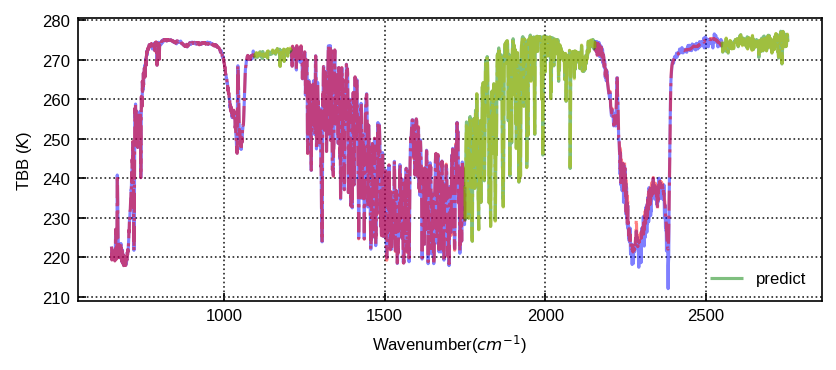

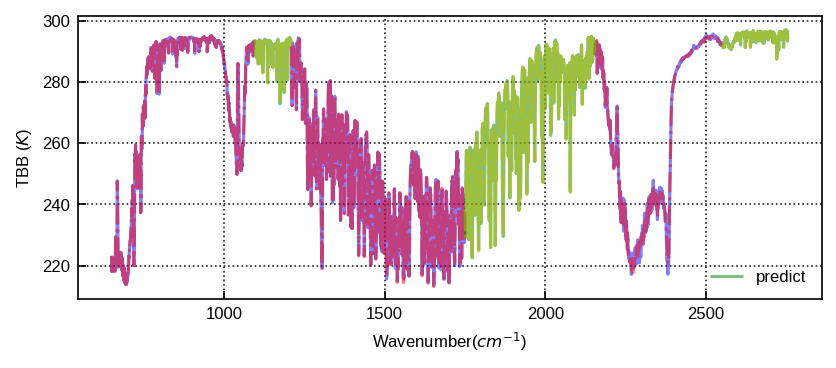

In [176]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], test_X_tbb[data_number][s: e], 'b-', alpha=alpha)
        plot_true_label = True
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true_repreject'
        plt.plot(wavenumber_X[s: e], test_X_tbb_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], 'g-', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict_repreject'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

In [12]:
model_data = {
    'train_X': train_X,
    'test_X': test_X,
    'train_Y': train_Y,
    'test_Y': test_Y,
}

In [13]:
print(index_X)
print(index_Y)

[[   0  713]
 [ 713 1578]
 [1578 2211]]
[[   0  183]
 [ 183  830]
 [ 830 1158]]


In [14]:
print(type(model_data['train_X']))
print(type(model_data['test_X']))
print(type(model_data['train_Y']))
print(type(model_data['test_Y']))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(model_data['train_X'].shape)
print(model_data['test_X'].shape)
print(model_data['train_Y'].shape)
print(model_data['test_Y'].shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(935202, 2211)
(233801, 2211)
(935202, 1158)
(233801, 1158)
(2211,)
(1158,)
(3, 2)
(3, 2)


In [15]:
print(np.where(model_data['train_X']<=0)[0].shape)
print(np.where(model_data['test_X']<=0)[0].shape)
print(np.where(model_data['train_Y']<=0)[0].shape)
print(np.where(model_data['test_Y']<=0)[0].shape)

print(np.where(np.isnan(model_data['train_X']))[0].shape)
print(np.where(np.isnan(model_data['test_X']))[0].shape)
print(np.where(np.isnan(model_data['train_Y']))[0].shape)
print(np.where(np.isnan(model_data['test_Y']))[0].shape)

(0,)
(0,)
(0,)
(0,)


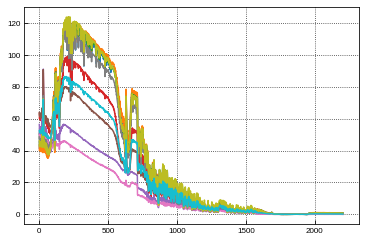

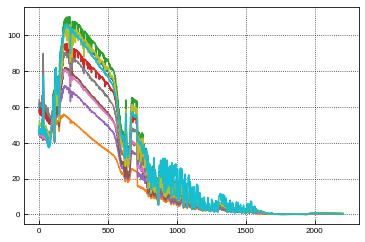

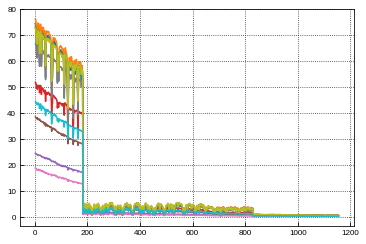

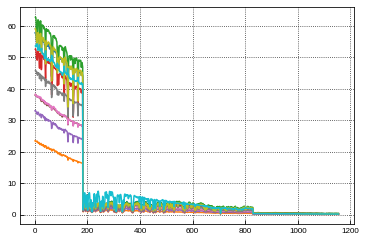

In [16]:
for i in range(0, 10):
    plt.plot(model_data['train_X'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['test_X'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['train_Y'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['test_Y'][i])
plt.show()

In [17]:
# 没有用错数据，但是Y重投影以后，与原来数据的差异特别大，这里需要Debug
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(model_data['train_X'], model_data['train_Y'])

print(lin_reg.coef_.T.shape)
print(lin_reg.intercept_.T.shape)

(2211, 1158)
(1158,)


In [18]:
predict_Y_linear = lin_reg.predict(model_data['test_X'])

In [19]:
def save_linear_model_attributes(coeff, intercept, out_file):
    """
    保存线性模型的属性
    :param coeff: 
    :param intercept: 
    :param out_file: 
    :return: 
    """
    compression = 'gzip'  # 压缩算法种类
    compression_opts = 1  # 压缩等级
    shuffle = True
    with h5py.File(out_file, 'w') as hdf5:
        hdf5.create_dataset('P0',
                            dtype=np.float32, data=coeff, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)
        hdf5.create_dataset('C0',
                            dtype=np.float32, data=intercept, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)
        hdf5.create_dataset('GAP_NUM',
                            dtype=np.int32, data=np.array([183, 647, 328]), compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)

In [20]:
model_attribute_file = 'Model/linear_model_attribute_test.h5'
# u = pca_x.components_.T
# p = lin_reg.coef_.T
# coeff = np.dot(u, p)
# intercept = lin_reg.intercept_.T - pca_x.mean_.dot(coeff)

coeff = lin_reg.coef_.T
intercept = lin_reg.intercept_.T

print(coeff.shape)
print(intercept.shape)
save_linear_model_attributes(coeff, intercept, model_attribute_file)

(2211, 1158)
(1158,)


In [21]:
mae = mean_absolute_error(model_data['test_Y'], predict_Y_linear)
mse = mean_squared_error(model_data['test_Y'], predict_Y_linear)
print(mae)
print(mse)

0.031022716
0.0038115685


In [187]:
# linear_model_attribute_file = os.path.join(model_dir, 'linear_model_attribute_business.h5')
# coef, intercept = get_linear_model_attributes(linear_model_attribute_file)

In [188]:
# lin_reg.coef_ = coef.T
# lin_reg.intercept_ = intercept.T
# predict_Y_linear = lin_reg.predict(test_X)

In [189]:
# mae = mean_absolute_error(test_Y, predict_Y_linear)
# mse = mean_squared_error(test_Y, predict_Y_linear)
# print(mae)
# print(mse)

In [22]:
# 去除预测结果中含无效值（<=0）的光谱
predict_Y_linear_tmp = predict_Y_linear.copy()
test_Y_linear_tmp = model_data['test_Y'].copy()
predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)
index = predict_Y_linear_tmp <= 0
predict_Y_linear_tmp[index] = np.nan
test_Y_linear_tmp[index] = np.nan
predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)

predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)
test_Y_linear_tmp = np.array(test_Y_linear_tmp)

(233801, 1158)
(233801, 1158)
(233798, 1158)
(233798, 1158)


In [23]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    fig = plt.figure(figsize=(6.4, 3), dpi=120)
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    lw = 1

    for s, d in index:
        ax1.plot(wavenumber[s:d], bias.mean(axis=0)[s:d], lw=lw)
        ax1.set_ylim(-0.2, 0.2)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], bias.std(axis=0)[s:d], lw=lw)
        ax2.set_ylim(0.0, 2)
        ax2.set_xlabel('Wavenumber $(cm^{-1})$')
        ax2.set_ylabel('TBB Bias Std $(K)$')

    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

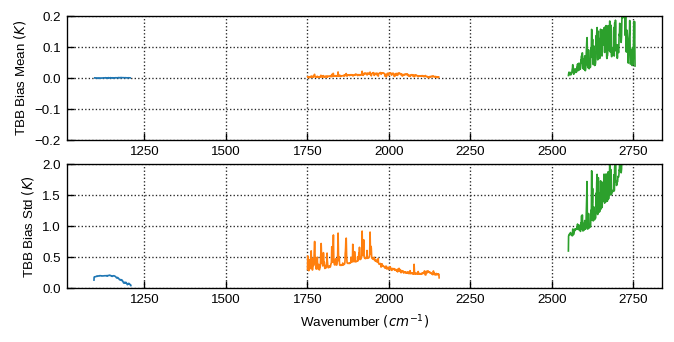

>>> Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_linear/0000_650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625.png


In [24]:
out_file = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '.png'

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_linear'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

out_file = os.path.join(result_dir, out_file)
test_tbb = rad2tbb(test_Y_linear_tmp, wavenumber_Y)
predict_tbb = rad2tbb(predict_Y_linear_tmp, wavenumber_Y)

plot_model_validate(test_tbb, predict_tbb, wavenumber_Y, index_Y, out_file)

In [25]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

In [26]:
test_Y_tbb = rad2tbb(model_data['test_Y'], wavenumber_Y)

In [27]:
predict_Y_tbb_linear = rad2tbb(predict_Y_linear, wavenumber_Y)

/home/cali/src/gap_filling/util.py:77: RuntimeWarning: invalid value encountered in log
  tbb = (c2 * center_wave) / np.log(1 + ((c1 * center_wave ** 3) / radiance))


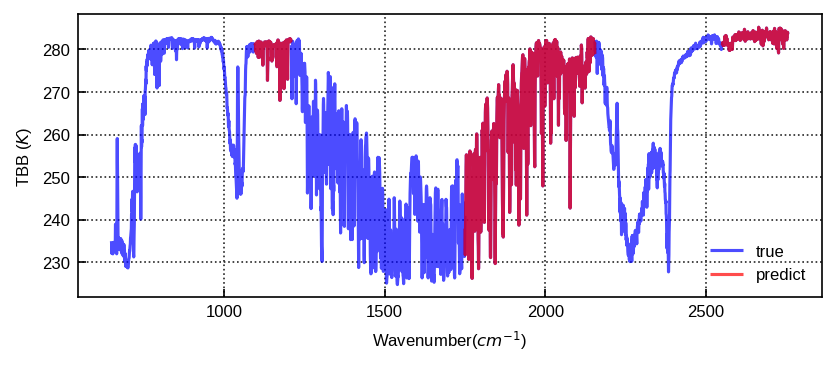

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_00.png


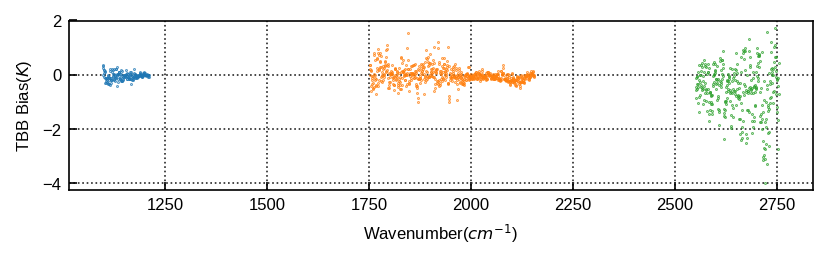

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_01.png


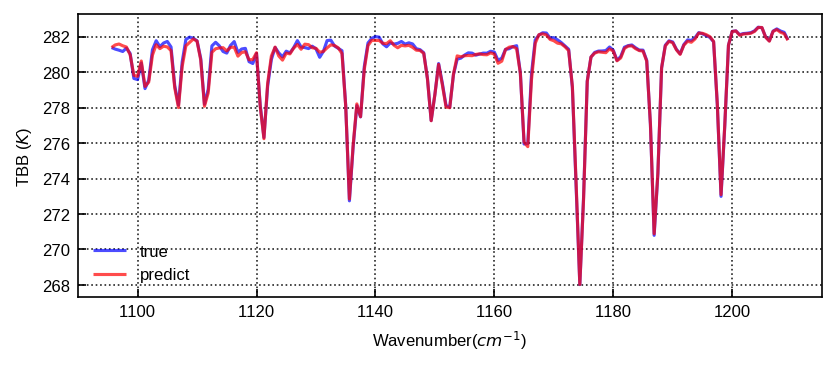

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_02.png


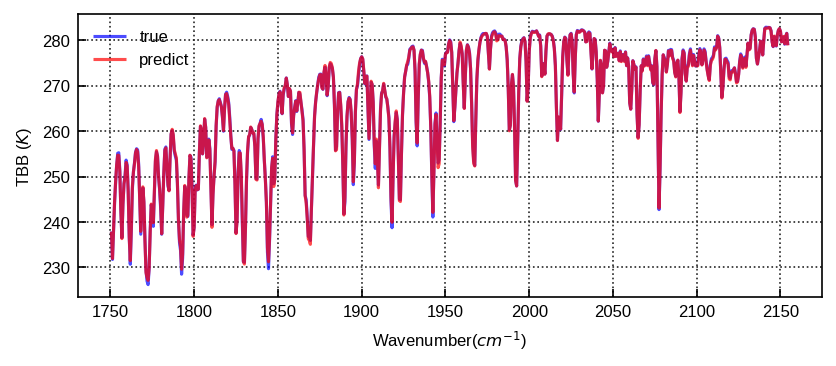

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_03.png


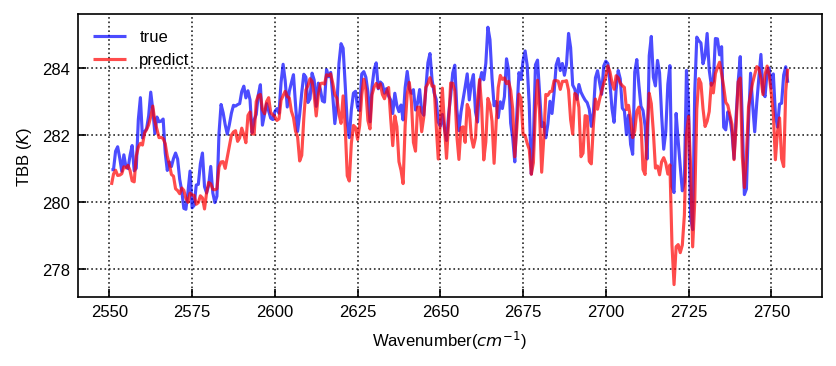

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_04.png


In [30]:
alpha = 0.7

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + "_dnn"
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

file_name = result_dir + '/s_{:04d}_{:02d}.png'

figsize1 = (6.4, 2.5)
figsize2 = (6.4, 1.5)

for data_number in range(0, 1):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], test_X_tbb[data_number][s: e], c='b', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='b', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='r', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=150)
    print(file_name.format(data_number, count))
    count += 1

    fig = plt.figure(figsize=figsize2, dpi=150)
    for s, e in index_Y:
        tbb_bias = predict_Y_tbb_linear[data_number][s: e] - test_Y_tbb[data_number][s: e]
        plt.scatter(wavenumber_Y[s: e], tbb_bias, s=0.1)
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=150)
    print(file_name.format(data_number, count))
    count += 1

    for s, e in index_Y:
        fig = plt.figure(figsize=figsize1, dpi=150)
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='b', alpha=alpha, label='true')
        plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], c='r', alpha=alpha, label='predict')
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count), dpi=150)
        print(file_name.format(data_number, count))
        count += 1